In [ ]:
'''
【项目08】  电商打折套路解析

作业要求
1、从现有数据中，分析出“各个品牌都有多少商品参加了双十一活动？”
要求：
① 计算得到：商品总数、品牌总数
② 双十一当天在售的商品占比情况（思考：是不是只有双十一当天在售的商品是“参与双十一活动的商品？”）
③ 未参与双十一当天活动的商品，在双十一之后的去向如何？
④ 真正参与双十一活动的品牌有哪些？其各个品牌参与双十一活动的商品数量分布是怎样的？
   * 用bokeh绘制柱状图表示
提示：
① 数据的“id”字段为商品的实际唯一标识，“title”字段则为商品在网页上显示的名称
   * 仔细看数据可以发现，同一个id的title不一定一样（双十一前后）
② 数据的“店名”字段为品牌的唯一标识
③ 按照商品销售节奏分类，我们可以将商品分为7类
   A. 11.11前后及当天都在售 → 一直在售
   B. 11.11之后停止销售 → 双十一后停止销售
   C. 11.11开始销售并当天不停止 → 双十一当天上架并持续在售
   D. 11.11开始销售且当天停止 → 仅双十一当天有售
   E. 11.5 - 11.10 → 双十一前停止销售
   F. 仅11.11当天停止销售 → 仅双十一当天停止销售
   G. 11.12开始销售 → 双十一后上架
④ 未参与双十一当天活动的商品，可能有四种情况：
   con1 → 暂时下架（F）
   con2 → 重新上架（E中部分数据，数据中同一个id可能有不同title，“换个马甲重新上架”），字符串查找特定字符 dataframe.str.contains('预售')
   con3 → 预售（E中部分数据，预售商品的title中包含“预售”二字）
   con4 → 彻底下架（E中部分数据），可忽略
⑤ 真正参加活动的商品 = 双十一当天在售的商品 + 预售商品 （可以尝试结果去重）
   通过上述几个指标计算，研究出哪些是真正参与双十一活动的品牌，且其商品数量是多少
   
2、哪些商品真的在打折呢？
要求：
① 针对每个商品，评估其打折的情况
② 针对在打折的商品，其折扣率是多少
   * 用bokeh绘制折线图：x轴为折扣率，y轴为商品数量
③ 按照品牌分析，不同品牌的打折力度
   * 用bokeh绘制浮动散点图，y坐标为品牌类型，x坐标为折扣力度
提示：
① 打折情况评估方法：
   真打折：商品的价格在10天内有波动、双11价格为10天内最低价、不存在涨价现象
   不打折：商品价格无变化
② 针对每个商品做price字段的value值统计，查看价格是否有波动，可以先用pd.cut将date分为不同周期：'双十一前','双十一当天','双十一后'，得到period字段
   data[['id','price','date']].groupby(['id','price']).min()
   针对统计出来的结果，如果按照id和price分组仍只有一个唯一值，则说明价格未变，没打折；否则为打折
③ 折扣率 = 双十一当天价格 / 双十一之前价格
④ 作图过程中，清除掉折扣率大于95%的数据

3、商家营销套路挖掘？
要求：
① 解析出不同品牌的参与打折商品比例及折扣力度，并


'''

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
% matplotlib inline

import warnings
warnings.filterwarnings('ignore') 


In [4]:
# 作业要求
# 1、从现有数据中，分析出“各个品牌都有多少商品参加了双十一活动？”
# 要求：
# ① 计算得到：商品总数、品牌总数
# ② 双十一当天在售的商品占比情况（思考：是不是只有双十一当天在售的商品是“参与双十一活动的商品？”）
# ③ 未参与双十一当天活动的商品，在双十一之后的去向如何？
# ④ 真正参与双十一活动的品牌有哪些？其各个品牌参与双十一活动的商品数量分布是怎样的？
#    * 用bokeh绘制柱状图表示
# 提示：
# ① 数据的“id”字段为商品的实际唯一标识，“title”字段则为商品在网页上显示的名称
#    * 仔细看数据可以发现，同一个id的title不一定一样（双十一前后）
# ② 数据的“店名”字段为品牌的唯一标识
# ③ 按照商品销售节奏分类，我们可以将商品分为7类
#    A. 11.11前后及当天都在售 → 一直在售
#    B. 11.11之后停止销售 → 双十一后停止销售
#    C. 11.11开始销售并当天不停止 → 双十一当天上架并持续在售
#    D. 11.11开始销售且当天停止 → 仅双十一当天有售
#    E. 11.5 - 11.10 → 双十一前停止销售
#    F. 仅11.11当天停止销售 → 仅双十一当天停止销售
#    G. 11.12开始销售 → 双十一后上架
# ④ 未参与双十一当天活动的商品，可能有四种情况：
#    con1 → 暂时下架（F）
#    con2 → 重新上架（E中部分数据，数据中同一个id可能有不同title，“换个马甲重新上架”），字符串查找特定字符 dataframe.str.contains('预售')
#    con3 → 预售（E中部分数据，预售商品的title中包含“预售”二字）
#    con4 → 彻底下架（E中部分数据），可忽略
# ⑤ 真正参加活动的商品 = 双十一当天在售的商品 + 预售商品 （可以尝试结果去重）
#    通过上述几个指标计算，研究出哪些是真正参与双十一活动的品牌，且其商品数量是多少

data = pd.read_excel(r'D:\BaiduNetdiskDownload\项目08电商打折套路解析\双十一淘宝美妆数据.xlsx')

id_sum = data['id'].drop_duplicates().index
print('商品总数为:%i个'%len(data['id'].drop_duplicates().index),'\n-----')
print('品牌总数为:%i个'%len(data['店名'].drop_duplicates().index),'\n-----')

data_11 = data[data['update_time']=='2016-11-11']
id_11 = data_11['id'].drop_duplicates().index
print('双十一当天在售商品%i个'%len(id_11),'占比%.3f'%(len(id_11)/len(id_sum)),'\n-----')
data_gp = data[['id','update_time']].groupby('id').agg(['min','max'])['update_time']

id_11 = data[data['update_time']=='2016-11-11']['id']
id_if_11 =pd.DataFrame({'id':id_11,'双11在售':1}) 

data_final = pd.merge(data_gp,id_if_11,on='id',how='left')
data_final['双11在售'][data_final['双11在售']!=1]=0
ys_11= data[data['title'].str.contains('预售')]['id'].unique()
data_bsale=pd.DataFrame({'id':ys_11,'是否预售':1})
data_final = pd.merge(data_final,data_bsale,on='id',how='left')
data_final['是否预售'][data_final['是否预售']!=1]=0
data_uniq = data.drop_duplicates('id')
data_final = pd.merge(data_final,data_uniq[['id','店名']],on='id',how='left')
print('双11后重新上架商品数:%i'%len(data_final[(data_final['双11在售']==0)&(data_final['max']>'2016-11-11')]),'\n------')
print('双11后下架商品数:%i'%len(data_final[(data_final['双11在售']==0)&(data_final['max']<'2016-11-11')]),'\n-----')
print('双11预售商品数%i'%len(data_final[data_final['是否预售']==1]),'\n-----')
ac_data = data_final[(data_final['双11在售']==1) | (data_final['是否预售']==1)]
print('真正参加活动的商品数:%i'%len(ac_data),'占比%.3f'%(len(ac_data)/len(data_final)))
data_brand = data_final.groupby('店名').agg({'id':'count','双11在售':'sum','是否预售':'sum'})
data_brand.reset_index(inplace=True)
data_brand.columns=['brand','商品总数','参与活动商品数','预售商品数']
print(data_brand)
fig = px.bar(data_brand,x='brand',y=['参与活动商品数','预售商品数'],barmode='overlay',\
             template='seaborn',title='各个品牌参与双十一活动的商品数量分布')
fig.show()

商品总数为:3502个 
-----
品牌总数为:22个 
-----
双十一当天在售商品2335个 占比0.667 
-----
双11后重新上架商品数:326 
------
双11后下架商品数:841 
-----
双11预售商品数485 
-----
真正参加活动的商品数:2789 占比0.796
   brand  商品总数  参与活动商品数  预售商品数
0   SKII    62     40.0   15.0
1    佰草集   279    208.0   32.0
2     倩碧   211    144.0   51.0
3     兰芝   157    105.0    4.0
4     兰蔻   168    112.0   28.0
5    妮维雅   156    127.0   15.0
6     娇兰   147     89.0   54.0
7   悦诗风吟   330    282.0   10.0
8    植村秀    97     61.0   26.0
9    欧珀莱   184    114.0   21.0
10   欧莱雅   247    188.0   22.0
11   玉兰油   142     64.0   15.0
12  相宜本草   167     92.0   18.0
13   美加净   188    124.0    2.0
14   美宝莲   102     67.0   23.0
15   自然堂   184     95.0   15.0
16    薇姿   101     49.0   22.0
17  蜜丝佛陀    54     35.0   16.0
18   资生堂   133     62.0   30.0
19    雅漾    79     58.0    9.0
20  雅诗兰黛   246    170.0   40.0
21   雪花秀    69     50.0   17.0


--------
 真打折的商品数量约占比24.73%，不打折的商品数量约占比75.27%


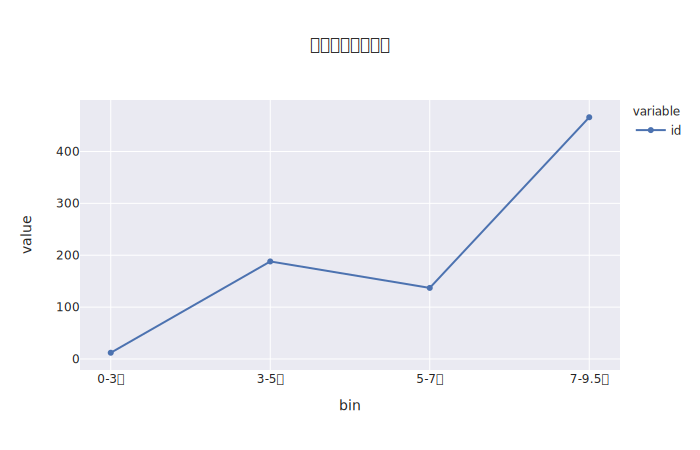

In [84]:
# 2、哪些商品真的在打折呢？
# 要求：
# ① 针对每个商品，评估其打折的情况
# ② 针对在打折的商品，其折扣率是多少
#    * 用bokeh绘制折线图：x轴为折扣率，y轴为商品数量
# ③ 按照品牌分析，不同品牌的打折力度
#    * 用bokeh绘制浮动散点图，y坐标为品牌类型，x坐标为折扣力度
# 提示：
# ① 打折情况评估方法：
#    真打折：商品的价格在10天内有波动、双11价格为10天内最低价、不存在涨价现象
#    不打折：商品价格无变化
# ② 针对每个商品做price字段的value值统计，查看价格是否有波动，可以先用pd.cut将date分为不同周期：'双十一前','双十一当天','双十一后'，得到period字段
#    data[['id','price','date']].groupby(['id','price']).min()
#    针对统计出来的结果，如果按照id和price分组仍只有一个唯一值，则说明价格未变，没打折；否则为打折
# ③ 折扣率 = 双十一当天价格 / 双十一之前价格
# ④ 作图过程中，清除掉折扣率大于95%的数据

data['date']=data['update_time'].dt.day
periods=[4,10,11,14]
data['period'] = pd.cut(data['date'],periods,labels=['双十一前','双十一当天','双十一后'])
data.head()
data_sale = data[['id','price','period']].groupby(['id','price']).min()
data_sale.reset_index(inplace=True)
id_counts = data_sale['id'].value_counts()
id_type1 = id_counts[id_counts==1].index
id_type2 = id_counts[id_counts!=1].index

n1=len(id_type1)
n2=len(id_type2)
print('--------\n','真打折的商品数量约占比%.2f%%，不打折的商品数量约占比%.2f%%' % (n2/len(id_counts)*100, n1/len(id_counts)*100))
result_be11 = data_sale[data_sale['period']=='双十一前']
result_11 =data_sale[data_sale['period']=='双十一当天']
result_sale = pd.merge(result_11,result_be11,on='id',how='left')

result_sale['折扣率']=result_sale['price_x']/result_sale['price_y']
# result_sale.head()
re_bins=[0,0.3,0.5,0.7,0.95]

result_sale['bin'] = pd.cut(result_sale['折扣率'],re_bins,labels=['0-3折','3-5折','5-7折','7-9.5折'])
result_sale.head()
result_fig = result_sale.groupby('bin')['id'].count()
result_fig
fig = px.scatter(result_fig,template='seaborn',title='打折商品折扣情况')
fig.update_traces(mode='lines+markers')
fig.show(renderer='svg')